In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
data_path = "tactical_dataset_with_results.csv"
df = pd.read_csv(data_path)

print(df.shape)
df.head()


(6928, 20)


,possession_ratio,num_passes,avg_pass_length,shots,xg,pressures,tackles,interceptions,avg_x_position,team_width,final_third_actions,ppda,match_id,team,competition,season,goals_for,goals_against,goal_diff,result
0,0.548188,651,17.239263,20,3.004243,220,18,7,63.809874,79.9,628,1.522449,3895302,Bayer Leverkusen,1. Bundesliga,2023/2024,5,0,5,Win
1,0.451812,521,20.402782,7,0.683733,212,34,10,49.425502,79.9,273,1.082031,3895302,Werder Bremen,1. Bundesliga,2023/2024,0,5,-5,Loss
2,0.380952,372,23.465847,9,0.545083,154,44,11,49.750242,79.9,308,1.406699,3895292,Union Berlin,1. Bundesliga,2023/2024,0,1,-1,Loss
3,0.619048,708,19.188975,20,2.563543,124,32,9,64.557318,79.9,720,1.460606,3895292,Bayer Leverkusen,1. Bundesliga,2023/2024,1,0,1,Win
4,0.547478,566,19.865822,17,1.441534,162,33,15,59.098136,79.9,460,1.266667,3895333,Eintracht Frankfurt,1. Bundesliga,2023/2024,1,5,-4,Loss


In [3]:
print(df['result'].value_counts(normalize=True) * 100)
print("Missing values:", df.isnull().sum().sum())


result
Win     38.495958
Loss    38.495958
Draw    23.008083
Name: proportion, dtype: float64
Missing values: 0


In [4]:
features = [
    'xg',
    'shots',
    'possession_ratio',
    'avg_x_position',
    'pressures',
    'tackles',
    'avg_pass_length'
]

X = df[features].values
y = df['result'].values


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, X_test.shape)


(5542, 7) (1386, 7)


In [6]:
model = GaussianNB(var_smoothing=1e-9)
model.fit(X_train, y_train)


,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


In [7]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5468975468975469
              precision    recall  f1-score   support

        Draw       0.44      0.04      0.08       319
        Loss       0.53      0.77      0.63       534
         Win       0.57      0.62      0.60       533

    accuracy                           0.55      1386
   macro avg       0.51      0.48      0.44      1386
weighted avg       0.53      0.55      0.49      1386



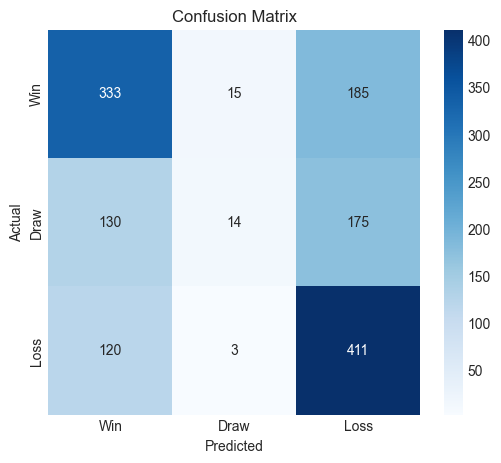

In [8]:
cm = confusion_matrix(y_test, y_pred, labels=['Win','Draw','Loss'])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Win','Draw','Loss'],
            yticklabels=['Win','Draw','Loss'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [9]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("CV mean:", cv_scores.mean())
print("CV std:", cv_scores.std())


CV mean: 0.5404164482914651
CV std: 0.008609972282348848


In [10]:
param_grid = {'var_smoothing': np.logspace(-12, -7, 20)}

grid = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best param:", grid.best_params_)
print("Best CV:", grid.best_score_)


Best param: {'var_smoothing': np.float64(1e-12)}
Best CV: 0.5404164482914651


In [11]:
sample = {
    'xg': 1.5,
    'shots': 13,
    'possession_ratio': 0.5,
    'avg_x_position': 58,
    'pressures': 160,
    'tackles': 36,
    'avg_pass_length': 20
}

X_new = scaler.transform([[sample[f] for f in features]])
pred = model.predict(X_new)[0]
prob = model.predict_proba(X_new)[0]

print("Prediction:", pred)
print(dict(zip(model.classes_, prob)))


Prediction: Win
{np.str_('Draw'): np.float64(0.19700285175107443), np.str_('Loss'): np.float64(0.33616340787058413), np.str_('Win'): np.float64(0.46683374037834163)}
